In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()
import copy
import collections

from functools import reduce  # Required in Python 3
import operator
#akin to built - in sum() but for product
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

from sympy.core.numbers import NegativeOne, One, Zero

In [3]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
    HamSQuad6D,
    HamSext6D
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket

from acchamiltoniansandmatrices.Utils.JupyterHelpFunctions import hide_toggle
from acchamiltoniansandmatrices.Utils.SymbolicFunctions import SymbolTrick, fixedpoints2D
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot

from acchamiltoniansandmatrices.Factorization.Factorization import truncate

In [4]:
class LieOperator(Expr):
    '''
    Defined algebra for the Lie operator:
    Addition: Hamiltonian functions get added into a new Lie operator
    Multiplication: Poisson bracket gets applied
    Exp: Lie Transfer Map gets applied
    BCH: Baker- Campbell - Hausdorff expansion gets applied as Lie Tranfer Map concatenation
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta
    '''
    
    
    _op_priority = 11.0

    is_commutative = False
    
    
    def __new__(cls, ham, indep_coords, indep_mom):
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
        
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
            
        obj = Expr.__new__(cls, ham, indep_coords, indep_mom)
        obj._ham = ham
        obj._indep_coords = indep_coords
        obj._indep_mom = indep_mom
        return obj
    
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        #Input has to be a function
        assert(not(S(ham.is_number))), 'Input has to be a function and not a number'
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
        
        
        
    
    #Algebraic properties 

    #Define Addition
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    def __add__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    def __radd__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)
    
    #Define Substraction
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rsub__')
    def __sub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__sub__')
    def __rsub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)
        
    #Define Multiplication
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return self.LieOperatorMul(other)
        
        
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if S(other).is_number:
            return LieOperator(other*self.ham,self.indep_coords,self.indep_mom)
        elif not isinstance(other, LieOperator):
            other = LieOperator(other,self.indep_coords,self.indep_mom) 
        return other.LieOperatorMul(self)
    
    
    def LieOperatorMul(_ham1, _ham2):
        if not isinstance(_ham2, LieOperator):
            _ham2 = LieOperator(_ham2,_ham1.indep_coords,_ham1.indep_mom) 
        if not collections.Counter(_ham1.indep_coords) == collections.Counter(_ham2.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return _ham1.Poisson(_ham2)
    
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        _h1 = self.ham
        _h2 = other.ham
        hp = S(0)
        for qi,pi in zip(self.indep_coords, self.indep_mom):
            hp += _h1.diff(qi) * _h2.diff(pi) 
            hp -= _h1.diff(pi) * _h2.diff(qi)
        return LieOperator(hp,self.indep_coords,self.indep_mom)
    
    
    #Exponential Map: Lie Transform Map
    #Calculate the exponential map of the Lie operator to the input cutoff
    def LieMap(self,other,power):
        s = S(0)
        
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*(self.ExpPowerLieBracket(other,i)).ham
        
        return LieOperator(s,self.indep_coords,self.indep_mom) 
    
    
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        _op1 = self
        _op2 = other
        
        
        if power > 0:
            hp = _op1*_op2
            
            for s in range(1,power):
                hp = _op1*hp
                
        else:
            if not isinstance(_op2, LieOperator):
                _op2 = LieOperator(_op2, self.indep_coords,self.indep_mom)
            
            hp = _op2
        
        return hp
    
    #Up to order 4 done manually to have a working copy, arbitrary ordered needs to be still written
    def BCH(self,other,n):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        elif n < 1:
            raise ValueError(n, ' is not a valid order. Number has to be natural.')
            
        _op1 = LieOperator(self.ham,self.indep_coords, self.indep_mom)
        _op2 = LieOperator(other.ham, other.indep_coords, other.indep_mom)
        
        
        temp = _op1 + _op2
        
        if n > 1:
            _xy = _op1 * _op2
            _yx = _op2 * _op1
            temp = temp + sympy.Rational(1,2) * _xy
        
        if n > 2:
            _xxy = _op1 * _xy
            _yyx = _op2 * _yx
            temp = temp + sympy.Rational(1,12) * _xxy + sympy.Rational(1,12) * _yyx
           
        if n > 3:
            _yxxy = _op2 * _xxy 
            temp = temp  - sympy.Rational(1,24) * _yxxy
        
        if n > 4:
            _xyxyx = _op1 * (_op2 * (_op1 * _yx))
            _yxyxy = _op2 * (_op1 * (_op2 * _xy))
            
            _xxxy = _op1 * _xxy
            _yyyx = _op2 * _yyx
            temp = temp + (sympy.Rational(1,120) * _xyxyx
                           + sympy.Rational(1,120) * _yxyxy
                           + sympy.Rational(1,360) * _op1 * _yyyx
                           + sympy.Rational(1,360) * _op2 * _xxxy
                           - sympy.Rational(1,720) * _op2 * _yyyx
                           - sympy.Rational(1,720) * _op1 * _xxxy
                          )
       
        return temp

In [20]:
sym_x, sym_y, sym_z, sym_px, sym_py, sym_pz = sympy.symbols('x y z p_x p_y \delta')

def AssignHam(element, order=2, length=1, strength=1,flag=1):
    '''
    Element:
    1 = drift space
    2 = quadrupole
    25 = skew quadrupole
    3 = sextupole
    35 = skew sextupole - tbp
    '''
    order=order+1
    if element == 1:
        H = drift(order, length)
    elif element == 2:
        H = quad(order, length, strength, flag)
    elif element == 25:
        H = skew_quad(order, length, strength, flag)
    elif element == 3:
        H = sext(order, length, strength, flag)
#     elif H == 35:
#         H = skew_sext(order, length, strength)
    else:
        raise ValueError(element, ' no such reference in library.')      
    
    return H


def drift(N, length, beta=1):
    H0 = sym_pz / beta
    _ftemp = sympy.sqrt((sym_pz + 1)**2 - sym_px**2 - sym_py**2 + (1 - 1/beta))
    _epstemp = sympy.symbols('e')
    
    if N == -1:
        H = H0 - _ftemp
    else:
        H = H0 - _ftemp.subs(sym_px,sym_px*_epstemp).subs(sym_py,sym_py*_epstemp).subs(
            sym_pz,sym_pz*_epstemp).series(_epstemp,n=N).removeO().subs(_epstemp,1)
    
    H = length * H
    
    return H


def quad(N, length, strength,flag):
    if flag == 1:
        H0 = AssignHam(1, N) #Drift space
    else:
        H0 = 0
        
    H = H0 + (strength / 2) * (sym_x**2 - sym_y**2)
    H = length * H

    return H    


def skew_quad(N, length, strength,flag):
    if flag == 1:
        H0 = AssignHam(1, N) #Drift space
    else:
        H0 = 0
        
    H = H0 + (strength / 2) * sym_x * sym_y
    H = length * H

    return H    


def sext(N, length, strength,flag):
    if flag == 1:
        H0 = AssignHam(1, N) #Drift space
    else:
        H0 = 0
        
    H = H0 + (strength / 6) * (sym_x**3 - 3 * sym_x * sym_y**2)
    H = length * H

    return H    

In [21]:
def truncate(LieHam,degree): #cutoff Hamiltonian at specified degree
    _epstemp = sympy.symbols('e')
    fct = LieHam.ham
    
    for i in LieHam.indep_coords:
        fct = fct.subs(i,i*_epstemp)
        
    for i in LieHam.indep_mom:
        fct = fct.subs(i,i*_epstemp)
    
    fct = fct.expand() 
    fct = fct + O(_epstemp**degree)
    fct = fct.removeO().subs(_epstemp,1)
    
    return fct

def RingHam(beamline,BCH_order,poly_cutoff): #combine beamline with BCH into one map
    poly_cutoff = poly_cutoff + 1
    for i,element in enumerate(beamline):
        if i == 0:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H_int = LieOperator(H0,[sym_x,sym_y,sym_z],[sym_px,sym_py,sym_pz])
        else:
            H0 = AssignHam(element[0],element[1],element[2],element[3],element[4])
            H0 = LieOperator(H0,[sym_x,sym_y,sym_z],[sym_px,sym_py,sym_pz])
            
            H_int = H_int.BCH(H0,BCH_order)
    
    temp_H = truncate(H_int,poly_cutoff) #cutoff Hamiltonian at speciefied polynomial degree
    
    H = LieOperator(temp_H,[sym_x,sym_y,sym_z],[sym_px,sym_py,sym_pz])
    
    
    return H

In [22]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

In [14]:
# Define constant number symbols in sympy - otherwise they are considered variables
LQF   = SymbolTrick("L_{QF}")
LQD   = SymbolTrick("L_{QD}")
LD    = SymbolTrick("L_D")
LD2   = SymbolTrick("L_{D2}")
KQF   = SymbolTrick("K_{QF}")
KQD   = SymbolTrick("K_{QD}")

rep = list(zip(
    [
        LD,
        LD2,
        LQF,
        LQD,
        KQF,
        KQD,
        delta
    ],
    [
        3.5805,
        3.5805,
        0.342,
        0.668,
        0.49,
        -0.4999,
        1.5e-3
    ]
)
          )


In [23]:
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")

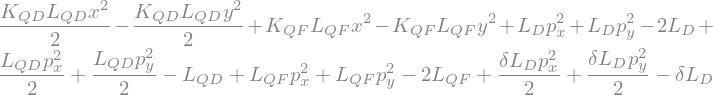

In [30]:
dld = symbols('\delta{L_D}')
thin = 1
order = 2

eldict = {
    'drift' : 1,
    'quad'  : 2,
    'squad' : 25,
    'sext'  : 3
}

beamline = [
    [eldict['quad'] , 2, LQF, KQF, thin],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 2, LQD, KQD, thin],
    [eldict['drift'], 4, LD + dld,   0, 0   ],
    [eldict['quad'] , 2, LQF, KQF, thin],
]

RingHam(beamline,1,2).ham

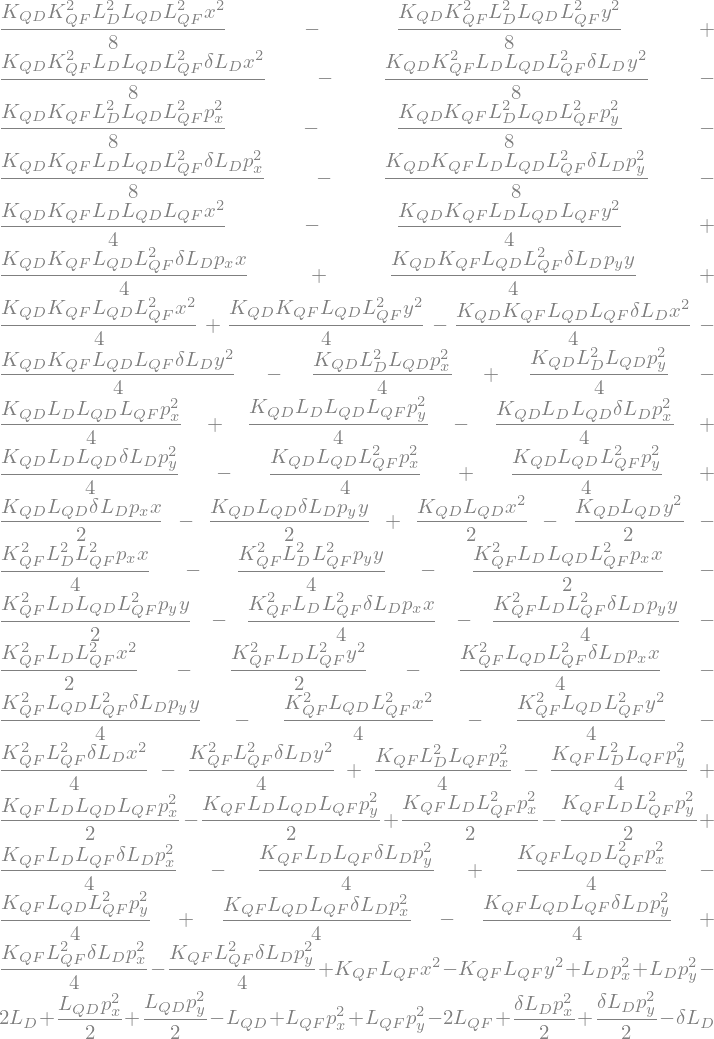

In [31]:
RingHam(beamline,2,2).ham